# 3D-LOTUS++ policy

This notebook shows an example to run the trained 3D-LOTUS++ policy on the RLBench simulator. 

Before starting, make sure that you have followed the instructions in [our Github repository](https://github.com/vlc-robot/robot-3dlotus?tab=readme-ov-file) to setup the environment and download our pretrained models.

In [1]:
import os
import numpy as np

from easydict import EasyDict
import yaml

import matplotlib.pyplot as plt

from genrobo3d.rlbench.environments import RLBenchEnv, Mover
from rlbench.backend.utils import task_file_to_task_class
from pyrep.errors import IKError, ConfigurationPathError
from rlbench.backend.exceptions import InvalidActionError

from genrobo3d.train.utils.misc import set_random_seed
from genrobo3d.evaluation.robot_pipeline import RobotPipeline

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
os.chdir('..') # locate in the robot-3dlotus directory

## Build the model

In [3]:
seed = 100

with open('genrobo3d/configs/rlbench/robot_pipeline.yaml', 'r') as f:
    pipeline_config = yaml.safe_load(f)
pipeline_config = EasyDict(pipeline_config)

pipeline_config.llm_planner.use_groundtruth = False
pipeline_config.object_grounding.use_groundtruth = False
pipeline_config.motion_planner.run_action_step = 5
pipeline_config.motion_planner.save_obs_outs = False

mp_expr_dir = pipeline_config.motion_planner.expr_dir
mp_ckpt_step = 140000
pipeline_config.motion_planner.checkpoint = os.path.join(
    mp_expr_dir, 'ckpts', f'model_step_{mp_ckpt_step}.pt'
)
pipeline_config.motion_planner.config_file = os.path.join(
    mp_expr_dir, 'logs', 'training_config.yaml'
)

In [4]:
set_random_seed(seed)
pipeline = RobotPipeline(pipeline_config)

> initializing model parallel with size 1
> initializing ddp with size 1
> initializing pipeline with size 1


02/10/2025 11:56:50 - INFO - llama.tokenizer -   Reloaded tiktoken model from /scratch/shichen/datasets/pretrained/meta-llama/Meta-Llama-3-8B-Instruct/tokenizer.model
02/10/2025 11:56:50 - INFO - llama.tokenizer -   #words: 128256 - BOS ID: 128000 - EOS ID: 128001


Loaded in 17.75 seconds
load detector: 0.04min


Some weights of SamModel were not initialized from the model checkpoint at facebook/sam-vit-huge and are newly initialized: ['prompt_encoder.shared_embedding.positional_embedding']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


load segmentor: 0.05min


## Build RLBench environment

In [5]:
taskvar = 'push_button+0'
task_str, variation_id = taskvar.split('+')
variation_id = int(variation_id)

In [6]:
image_size = [256, 256]
mover_max_tries = 10
max_steps = 25

In [7]:
env = RLBenchEnv(
    data_path='',
    apply_rgb=True,
    apply_pc=True,
    apply_mask=True,
    headless=True,
    image_size=image_size,
    cam_rand_factor=0,
)

In [8]:
env.env.launch()
task_type = task_file_to_task_class(task_str)
task = env.env.get_task(task_type)
task.set_variation(variation_id)

move = Mover(task, max_tries=mover_max_tries)


QStandardPaths: XDG_RUNTIME_DIR points to non-existing path '/run/user/666446', please create it with 0700 permissions.


## Run policy

Instructions: ['push the maroon button', 'push down the maroon button', 'press the button with the maroon base', 'press the maroon button']
Initial observation


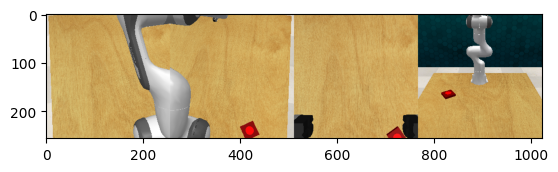

In [9]:
demo_id = 0

instructions, obs = task.reset()

print('Instructions:', instructions)

print('Initial observation')
plt.imshow(np.concatenate([obs.left_shoulder_rgb, obs.right_shoulder_rgb, obs.wrist_rgb, obs.front_rgb], 1))
plt.show()

In [10]:
obs_state_dict = env.get_observation(obs)
move.reset(obs_state_dict['gripper'])

Step id: 0
High-level plans [{'action': 'push down', 'object': 'maroon button', 'target': None, 'is_target_variable': False, 'is_object_variable': False, 'not_objects': None, 'ret_val': 'button'}]


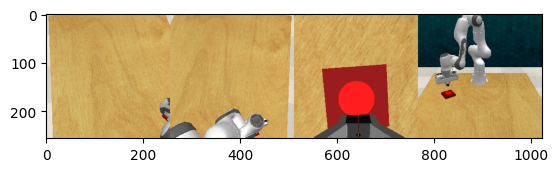

Step id: 1


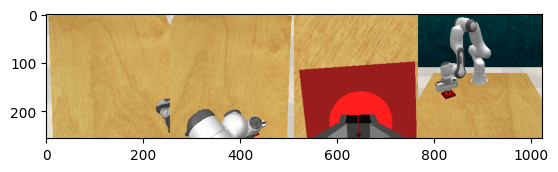

Reward: 1.0


In [11]:
cache = None

for step_id in range(max_steps):
    # fetch the current observation, and predict one action
    batch = {
        'task_str': task_str,
        'variation': variation_id,
        'step_id': step_id,
        'obs_state_dict': obs_state_dict,
        'episode_id': demo_id,
        'instructions': instructions,
        'cache': cache,
    }

    output = pipeline.predict(**batch)
    action = output["action"]
    cache = output["cache"]

    print('Step id:', step_id)
    if step_id == 0:
        print('High-level plans', cache['highlevel_plans'])

    if action is None:
        break

    # update the observation based on the predicted action
    try:
        obs, reward, terminate, _ = move(action, verbose=False)
        plt.imshow(np.concatenate([obs.left_shoulder_rgb, obs.right_shoulder_rgb, obs.wrist_rgb, obs.front_rgb], 1))
        plt.show()
        
        obs_state_dict = env.get_observation(obs)  # type: ignore

        if reward == 1:
            break
        if terminate:
            print("The episode has terminated!")
    except (IKError, ConfigurationPathError, InvalidActionError) as e:
        print(taskvar, demo_id, step_id, e)
        reward = 0
        break

print('Reward:', reward)

In [12]:
env.env.shutdown()